*This notebook was created by [Sergey Tomin](http://www.xfel.eu/organization/staff/tomin_sergey/) and [Igor Zagorodnov](http://www.desy.de/~zagor/) for Workshop: [Designing future X-ray FELs](http://www.xrayfels.co.uk/). Source and license info is on [GitHub](https://github.com/iagapov/ocelot/tree/dev/docs). August 2016. *

# Tutorial N4.  Wakefields.
## Chirper.
Influence of corrugated structure on the electron beam.
This example based on the work: [I. Zagorodnov, G. Feng, T. Limberg. Corrugated structure insertion for extending the SASE bandwidth up to 3% at the European XFEL](https://arxiv.org/abs/1607.07642). 

Gerometry of the corrugated structure. The blue ellipse represents an electron beam
propagating along the z axis.

<img src="4_corrugated_str.png" />

## Wakefields
In order to take into account the impact of the wake field on the beam the longitudinal wake function
of point charge through the second order Taylor expansion is used.
In general case it uses 13 one-dimensional functions to represent the  longitudinal component of the wake
function for arbitrary sets of the source and the wittness particles near to the reference axis.
The wake field impact on the beam is included as series of kicks.

The implementation of the wakefields follows closely the approach described 
in:
* [O. Zagorodnova, T. Limberg, Impedance budget database for the European XFEL,
in Proceedings of 2009 Particle Accelerator Conference,(Vancouver, Canada, 2009)](http://pubdb.xfel.eu/record/93956)
* [M. Dohlus, K. Floettmann, C. Henning, Fast particle tracking with wake 
fields, Report No. DESY 12-012, 2012.](https://arxiv.org/abs/1201.5270)

#### This example will cover the following topics:
* Initialization of the wakes and the places of their applying
* tracking of second order with wakes

#### Requirements 
* beam_chirper.ast    - input file, initial beam distribution in [ASTRA](http://www.desy.de/~mpyflo/) format (was obtained from s2e simulation performed with ASTRA and [CSRtrack](http://www.desy.de/fel-beam/psviewer/index.html)).
* wake_vert_1m.txt - wake table of the vertical corrugated structure (was calculated with [ECHO](http://www.desy.de/~zagor/WakefieldCode_ECHOz/))
* wake_hor_1m.txt - wake table of the vertical corrugated structure (was calculated with [ECHO](http://www.desy.de/~zagor/WakefieldCode_ECHOz/))

### Import of modules

In [ ]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

# this python library provides generic shallow (copy) and deep copy (deepcopy) operations 
from copy import deepcopy
import time

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

# load beam distribution
# this function convert Astra beam distribution to Ocelot format - ParticleArray. ParticleArray is designed for tracking.
# in order to work with converters we have to import specific module from ocelot.adaptors
from ocelot.adaptors.astra2ocelot import *

### Layout of the corrugated structure insertion. Create Ocelot lattice <img src="4_layout.png" />

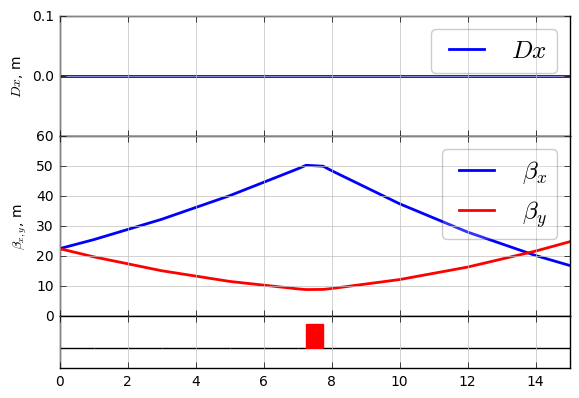

In [2]:
D00m25 = Drift(l = 0.25)
D01m = Drift(l = 1)
D02m = Drift(l = 2)

# Create markers for defining places of the wakes applying 
w1_start = Marker()
w1_stop = Marker()

w2_start = Marker()
w2_stop = Marker()

w3_start = Marker()
w3_stop = Marker()

w4_start = Marker()
w4_stop = Marker()

w5_start = Marker()
w5_stop = Marker()

w6_start = Marker()
w6_stop = Marker()
# quadrupoles
Q1 = Quadrupole(l = 0.5, k1 = 0.215)

# lattice
lattice = (D01m, w1_start, D02m, w1_stop, w2_start, D02m, w2_stop, w3_start, D02m, w3_stop, D00m25, Q1,
           D00m25, w4_start, D02m, w4_stop, w5_start, D02m, w5_stop, w6_start, D02m, w6_stop, D01m)

# creation MagneticLattice
method = MethodTM()
method.global_method = SecondTM
lat = MagneticLattice(lattice, method=method)

# calculate twiss functions with initial twiss parameters
tws0 = Twiss()
tws0.E = 14  # in GeV
tws0.beta_x = 22.5995
tws0.beta_y = 22.5995
tws0.alpha_x = -1.4285
tws0.alpha_y = 1.4285
tws = twiss(lat, tws0, nPoints=None)
# ploting twiss paramentrs.
plot_opt_func(lat, tws, top_plot=["Dx"], fig_name="i1", legend=False)
plt.show()

## Load beam file

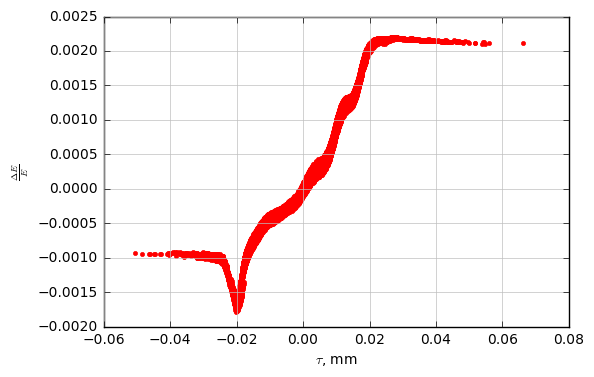

In [4]:
# load and convert ASTRA file to OCELOT beam distribution
# p_array_init = astraBeam2particleArray(filename='beam_chirper.ast')

# save ParticleArray to compresssed numpy array 
# save_particle_array("chirper_beam.npz", p_array_init)
p_array_init = load_particle_array("chirper_beam.npz")

plt.plot(-p_array_init.tau()*1000, p_array_init.p(), "r.")
plt.grid(True)
plt.xlabel(r"$\tau$, mm")
plt.ylabel(r"$\frac{\Delta E}{E}$")
plt.show()

## Initialization of the wakes and the places of their applying 

In [5]:
from ocelot.cpbd.wake3D import *

# load wake tables of corrugated structures
wk_vert = WakeTable('wake_vert_1m.txt')
wk_hor = WakeTable('wake_hor_1m.txt')

# creation of wake object with parameters 
wake_v1 = Wake()
# w_sampling - defines the number of the equidistant sampling points for the one-dimensional
# wake coefficients in the Taylor expansion of the 3D wake function.
wake_v1.w_sampling = 500
wake_v1.wake_table = wk_vert
wake_v1.step = 1 # step in Navigator.unit_step, dz = Navigator.unit_step * wake.step [m]

wake_h1 = Wake()
wake_h1.w_sampling = 500
wake_h1.wake_table = wk_hor
wake_h1.step = 1

wake_v2 = deepcopy(wake_v1) 

wake_h2 = deepcopy(wake_h1)

wake_v3 = deepcopy(wake_v1) 

wake_h3 = deepcopy(wake_h1)

## Add the wakes in the lattice
Navigator defines step (dz) of tracking and which, if it exists, physical process will be applied on each step.
In order to add collective effects (Space charge, CSR or wake) method add_physics_proc() must be run.

**Method:**
* Navigator.add_physics_proc(physics_proc, elem1, elem2)
    - physics_proc - physics process, can be CSR, SpaceCharge or Wake,
    - elem1 and elem2 - first and last elements between which the physics process will be applied.

Also must be define unit_step in [m] (by default 1 m). unit_step is minimal step of tracking for any collective effect. 
For each collective effect must be define number of unit_steps so step of applying physics process will be 

dz = unit_step*step [m]

In [6]:
navi = Navigator(lat)

# add physics proccesses
navi.add_physics_proc(wake_v1, w1_start, w1_stop)
navi.add_physics_proc(wake_h1, w2_start, w2_stop)
navi.add_physics_proc(wake_v2, w3_start, w3_stop)
navi.add_physics_proc(wake_h2, w4_start, w4_stop)
navi.add_physics_proc(wake_v3, w5_start, w5_stop)
navi.add_physics_proc(wake_h3, w6_start, w6_stop)

# definiing unit step in [m]
navi.unit_step = 0.2 

# deep copy of the initial beam distribution 
p_array = deepcopy(p_array_init)
print("tracking with Wakes .... ")
start = time.time()
tws_track, p_array = track(lat, p_array, navi)
print("\n time exec:", time.time() - start, "sec")

tracking with Wakes .... 
z = 15.0 / 15.0 : applied: 
 time exec: 90.2150206565857 sec


## Longitudinal beam distribution

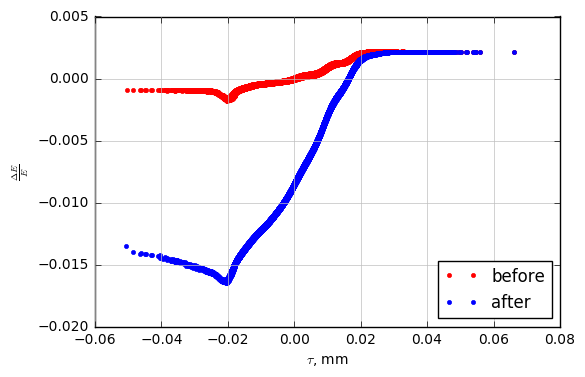

In [7]:
tau0 = p_array_init.tau()
p0 = p_array_init.p()

tau1 = p_array.tau()
p1 = p_array.p()

plt.figure(1)
plt.plot(-tau0*1000, p0, "r.", -tau1*1000, p1, "b.")
plt.legend(["before", "after"], loc=4)
plt.grid(True)
plt.xlabel(r"$\tau$, mm")
plt.ylabel(r"$\frac{\Delta E}{E}$")
plt.show()

### Beam distribution

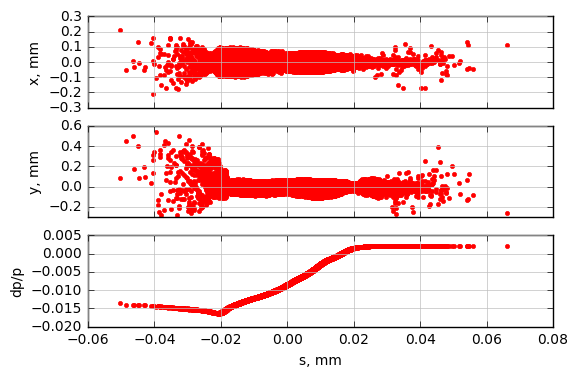

In [8]:
tau = np.array([p.tau for p in p_array])
dp = np.array([p.p for p in p_array])
x = np.array([p.x for p in p_array])
y = np.array([p.y for p in p_array])

ax1 = plt.subplot(311)
ax1.plot(-tau*1000, x*1000, 'r.')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel("x, mm")
plt.grid(True)

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(-tau*1000, y*1000, 'r.')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel("y, mm")
plt.grid(True)

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(-tau*1000, dp, 'r.')
plt.ylabel("dp/p")
plt.xlabel("s, mm")
plt.grid(True)

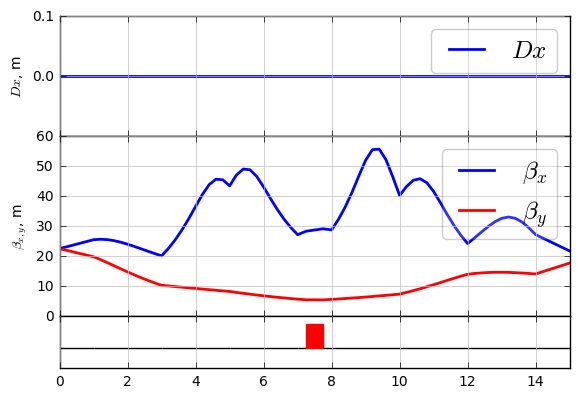

In [9]:
# plotting twiss parameters.
plot_opt_func(lat, tws_track, top_plot=["Dx"], fig_name="i1", legend=False)
plt.show()